In [1]:
from gEcon.classes.model import gEconModel
from gEcon.shared.dynare_convert import make_mod_file
from gEcon.plotting import plotting as gp

import numpy as np
import sympy as sp

# Load Model - Basic Model

This GCN file is fully compatable with the original R version of gEcon, and doesn't include any of the new features of gEcon.py.

If you look at the file, it also includes an `options` and `tryreduce` block. Note that these **DO NOT** do anything in gEcon.py. They are parsed and saved for compatability with GCN files written for the R version only (for now).

In [2]:
file_path = 'GCN Files/RBC_basic.gcn'
model = gEconModel(file_path, verbose=True)

Model Building Complete.
Found:
	13 equations
	13 variables
	1 stochastic shock
		 0 / 1 have a defined prior. 
	6 parameters
		 0 / 6 have a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations

All the FoC are saved in the model object and can be manipulated using Sympy if needed

In [3]:
for eq in model.system_equations:
    display(eq)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

beta*U_t+1 + C_t**(1 - sigma_C)/(1 - sigma_C) - L_t**(sigma_L + 1)/(sigma_L + 1) - U_t

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

-lambda_t + q_t

beta*(lambda_t+1*r_t+1 + q_t+1*(1 - delta)) - q_t

1 - mc_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

-K_t-1*r_t - L_t*w_t - TC_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha)*mc_t - r_t

A_t*K_t-1**alpha*mc_t*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Calibrating Relationships

In [4]:
for eq in model.calibrating_equations:
    display(eq)

# Solve Steady State

In [5]:
model.steady_state()
model.print_steady_state()

Steady state found! Sum of squared residuals is 8.689841288799523e-28
A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
TC_ss             -3.073
U_ss            -148.616
Y_ss               3.073
lambda_ss          0.276
mc_ss              1.000
q_ss               0.276
r_ss               0.030
w_ss               2.436


In addition, the following parameter values were calibrated:


## Steady State Equations

In [8]:
for eq in model.steady_state_system:
    display(eq)

-C_ss - I_ss + K_ss*r_ss + L_ss*w_ss

I_ss + K_ss*(1 - delta) - K_ss

beta*U_ss + C_ss**(1 - sigma_C)/(1 - sigma_C) - L_ss**(sigma_L + 1)/(sigma_L + 1) - U_ss

-lambda_ss + C_ss**(-sigma_C)

-L_ss**sigma_L + lambda_ss*w_ss

-lambda_ss + q_ss

beta*(lambda_ss*r_ss + q_ss*(1 - delta)) - q_ss

1 - mc_ss

A_ss*K_ss**alpha*L_ss**(1 - alpha) - Y_ss

-K_ss*r_ss - L_ss*w_ss - TC_ss

alpha*A_ss*K_ss**(alpha - 1)*L_ss**(1 - alpha)*mc_ss - r_ss

A_ss*K_ss**alpha*mc_ss*(1 - alpha)/L_ss**alpha - w_ss

rho_A*log(A_ss) - log(A_ss)

# Perturbation Solution

In [6]:
model.solve_model()

Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


# Simulation

In [7]:
simulation = model.simulate(shock_cov_matrix=np.eye(1) * 0.01, n_simulations=100)

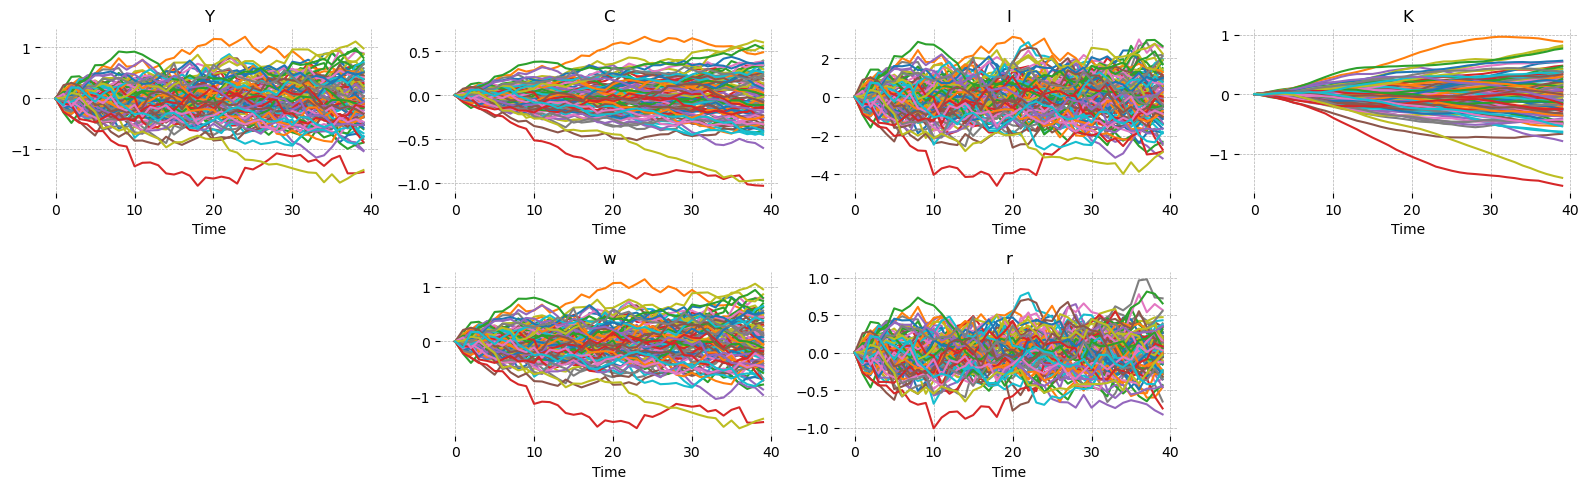

In [8]:
gp.plot_simulation(simulation, vars_to_plot=['Y', 'C', 'I', 'K', 'w', 'r'],
                   n_cols=4, figsize=(16, 5));

# Impulse Response Functions

In [9]:
irf = model.impulse_response_function(shock_size=0.01, simulation_length=40)

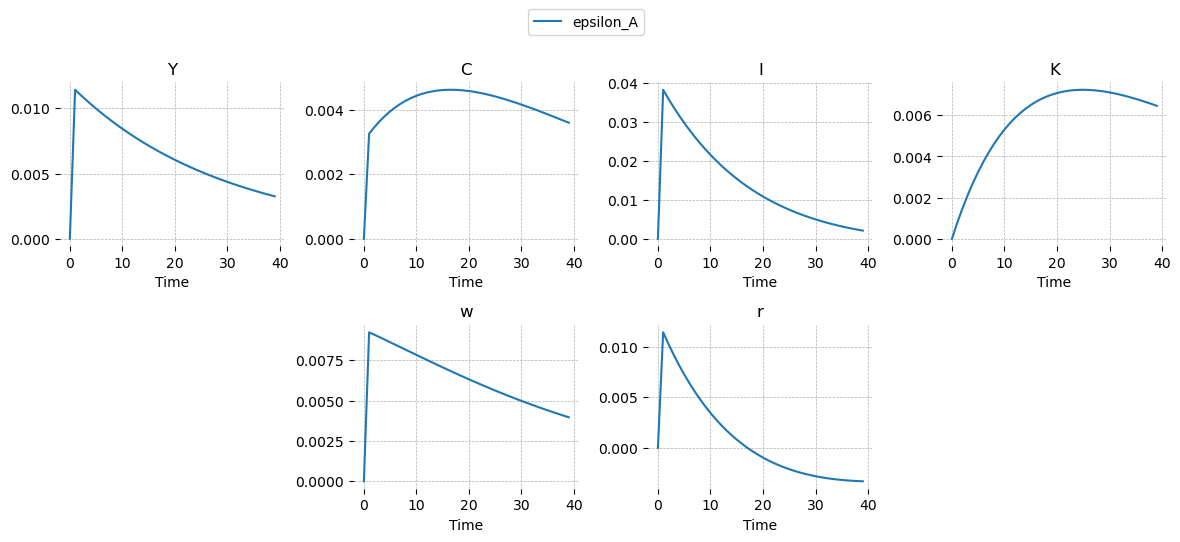

In [10]:
gp.plot_irf(irf, vars_to_plot=['Y', 'C', 'I', 'K', 'w', 'r'],
            n_cols=4, figsize=(12, 5), legend=True);

# Covnert to Dynare

In [11]:
print(make_mod_file(model))

var A, C, I, K, L, TC, U, Y, mc, q, r, var_lambda, w;
varexo epsilon_A;

parameters param_alpha, param_beta, param_delta, rho_A;
parameters sigma_C, sigma_L;

param_alpha = 0.35;
param_beta = 0.99;
param_delta = 0.02;
rho_A = 0.95;
sigma_C = 1.5;
sigma_L = 2.0;

model;
-C - I + K(-1) * r + L * w = 0;
I - K + K(-1) *(1 - param_delta) = 0;
C ^(1 - sigma_C) /(1 - sigma_C) - L ^(sigma_L + 1) /(sigma_L + 1) - U + U(1) * param_beta = 0;
-var_lambda + C ^(- sigma_C) = 0;
-L ^ sigma_L + var_lambda * w = 0;
q - var_lambda = 0;
param_beta *(q(1) *(1 - param_delta) + r(1) * var_lambda(1)) - q = 0;
1 - mc = 0;
A * K(-1) ^ param_alpha * L ^(1 - param_alpha) - Y = 0;
-K(-1) * r - L * w - TC = 0;
A * K(-1) ^(param_alpha - 1) * L ^(1 - param_alpha) * param_alpha * mc - r = 0;
A * K(-1) ^ param_alpha * mc *(1 - param_alpha) / L ^ param_alpha - w = 0;
epsilon_A + rho_A * log(A(-1)) - log(A) = 0;
end;

initval;
A = 1.0000;
C = 2.3584;
I = 0.7146;
K = 35.7323;
L = 0.8201;
TC = -3.0731;
U = -148.6156;
Y = 

# Adding a steady state block

RBC_steady_state.gcn shows how you can define a steady state in the GCN file to make the job of the numerical solver easier. 

* If you provide a complete steady-state solution, gEcon.py will check the residuals of your solution and report if there is an error, but will not resort to using a numerical solver.

* If you provide a partial steady-state solution, the relationships you provide will be substituted into the remaining equations, the system will be reduced via Sympy.simplify, and the remaining system of equations will be passed to the numerical solver.

In [12]:
file_path = 'GCN Files/RBC_steady_state.gcn'
model = gEconModel(file_path, verbose=True)

Model Building Complete.
Found:
	13 equations
	13 variables
	1 stochastic shock
		 0 / 1 have a defined prior. 
	6 parameters
		 0 / 6 have a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Steady-State Equations

Steady state equations are stored in the `model.steady_state_relationships` dictionary, with string keys of the form "Y_ss". I convert them to TimeAwareSymbols here to show the equations.

In [13]:
from gEcon.classes.time_aware_symbol import TimeAwareSymbol
for var, eq in model.steady_state_relationships.items():
    sp_var = TimeAwareSymbol(var.split('_')[0], time_index='ss')
    display(sp.Eq(sp_var, eq))

Eq(A_ss, 1.0)

Eq(C_ss, ((alpha**2/(-(1 - delta) + 1/beta))**(sigma_L + 1)/(1 - alpha)**sigma_L)**(1/sigma_C)*(((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L)))**((-sigma_L)/sigma_C))

Eq(I_ss, alpha*delta*((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L))/(-(1 - delta) + 1/beta))

Eq(K_ss, alpha*((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L))/(-(1 - delta) + 1/beta))

Eq(L_ss, ((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L))*(1 - alpha)*(-(1 - delta) + 1/beta)/alpha**2)

Eq(P_ss, 1.0)

Eq(TC_ss, -alpha*((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L)) - ((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L))*(1 - alpha))

Eq(U_ss, (((alpha**2/(-(1 - delta) + 1/beta))**(sigma_L + 1)/(1 - alpha)**sigma_L)**(1/sigma_C)*(((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L)))**((-sigma_L)/sigma_C))**(1 - sigma_C)/((1 - beta)*(1 - sigma_C)) - (((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L))*(1 - alpha)*(-(1 - delta) + 1/beta)/alpha**2)**(sigma_L + 1)/(sigma_L + 1))

Eq(Y_ss, ((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L)))

Eq(lambda_ss, (((alpha**2/(-(1 - delta) + 1/beta))**(sigma_L + 1)/(1 - alpha)**sigma_L)**(1/sigma_C)*(((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L)))**((-sigma_L)/sigma_C))**(-sigma_C))

Eq(q_ss, (((alpha**2/(-(1 - delta) + 1/beta))**(sigma_L + 1)/(1 - alpha)**sigma_L)**(1/sigma_C)*(((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*(alpha**2*(alpha**2/((1 - alpha)*(-(1 - delta) + 1/beta)))**sigma_L/(-(1 - delta) + 1/beta))**(1/(sigma_C + sigma_L)))**((-sigma_L)/sigma_C))**(-sigma_C))

Eq(r_ss, -(1 - delta) + 1/beta)

Eq(w_ss, alpha**2/(-(1 - delta) + 1/beta))

## Solve Steady State

In [14]:
from gEcon.solvers.steady_state import SteadyStateSolver

In [15]:
solver = SteadyStateSolver(model)

In [16]:
model.steady_state()
model.print_steady_state()

Steady state NOT found. Sum of squared residuals is 3.1864577657026114
Values come from the latest solver iteration but are NOT a valid steady state.
A_ss               1.000
C_ss               3.662
I_ss               1.110
K_ss              55.480
L_ss               0.762
P_ss               1.000
TC_ss             -4.771
U_ss            -104.663
Y_ss               4.771
lambda_ss          0.143
q_ss               0.143
r_ss               0.030
w_ss               4.070


In addition, the following parameter values were calibrated:
